Explain what is up in this notebook here !

In [1]:
%%HTML
<video width="480" height="360" controls>
  <source src="../openai_lunarlander_video.mp4" type="video/mp4">
</video>

In [2]:
%reload_ext autoreload
%autoreload 2

import sys
sys.path.append('..')

In [3]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from IPython.display import clear_output
import world
from dqn_agent import DQNAgent
from visualization_utils import *

%matplotlib inline

In [4]:
# from IPython import display as ipythondisplay
# from pyvirtualdisplay import Display
# display = Display(visible=0, size=(1400, 900))
# display.start()

In [5]:
class DoNothingAgent(object):
    
    name = 'do_nothing_agent'

    def __init__(self):
        pass

    def act(self, world_state):
        return 0

    
agent = DoNothingAgent()

_ = world.run_episode(agent)

In [6]:
%%HTML
<video width="480" height="360" controls>
  <source src="./video/do_nothing_agent/openaigym.video.5.1906.video000000.mp4" type="video/mp4">
</video>

In [7]:
class RandomAgent(object):
    
    name = 'random_agent'

    def __init__(self, num_actions=4):
        self.num_actions = num_actions

    def act(self, world_state):
        return random.randint(0, self.num_actions-1)

    
agent = RandomAgent()

_ = world.run_episode(agent)

In [8]:
class TrainedBehaviorAgent(object):
    
    name = 'trained_behavior_agent'

    def __init__(self):
        self.dqn_agent = DQNAgent()
        self.dqn_agent.qnetwork_local.load_state_dict(torch.load('../checkpoint0.pth'))
        self.dqn_agent.qnetwork_local.fc1.cpu()
        self.dqn_agent.qnetwork_local.fc2.cpu()
        self.dqn_agent.qnetwork_local.fc3.cpu()

    def act(self, world_state):
        return self.dqn_agent.act(world_state)
    
    def brain_state(self, world_state):
        
        brain_state = []
        
        network = self.dqn_agent.qnetwork_local
        x = world_state
        activations = x
        for i, subnet in enumerate(network.children()):
            try:
                subbrain_state = subnet.weight.detach().clone().cpu().numpy() * activations.detach().clone().cpu().numpy()
            except AttributeError:
                subbrain_state = subnet.weight.detach().clone().cpu().numpy() * activations
            brain_state.append(subbrain_state)
            activations = F.relu(subnet.cpu()(torch.tensor(activations)))
            

        return brain_state
        

    
agent = TrainedBehaviorAgent()

episode_history = world.run_episode(agent)

/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


In [9]:
print(agent.dqn_agent.qnetwork_local)

QNetwork(
  (fc1): Linear(in_features=8, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=4, bias=True)
)


In [10]:
agent.dqn_agent.qnetwork_local.fc2.weight.is_cuda

False

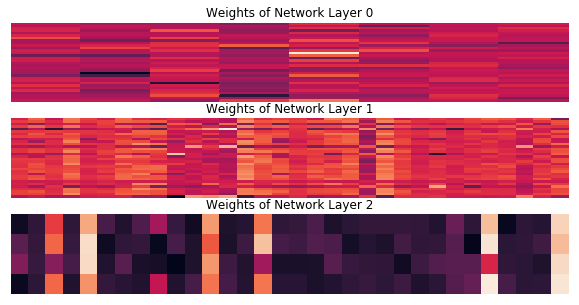

In [11]:
visualize_weights(agent.dqn_agent.qnetwork_local)

../visualization_utils.py:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  activations = F.relu(subnet.cpu()(torch.tensor(activations)))


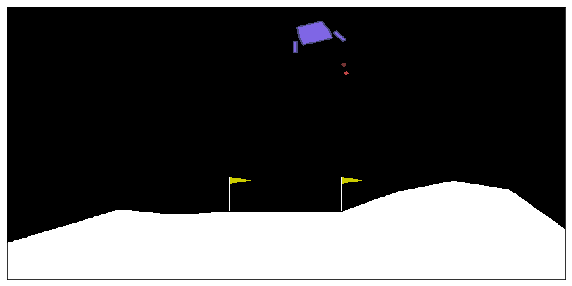

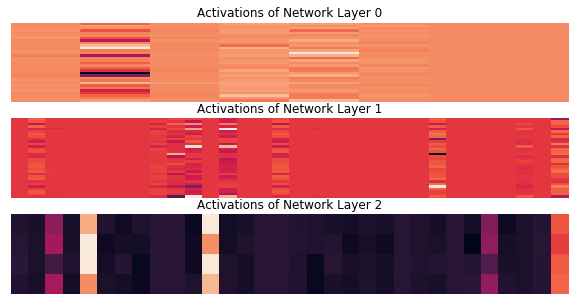

In [12]:
episode_index = 50
visualize_state(episode_history['world_image'][episode_index])
visualize_activations(agent.dqn_agent.qnetwork_local, episode_history['state'][episode_index])

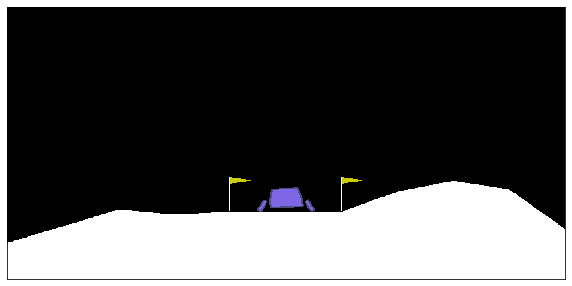

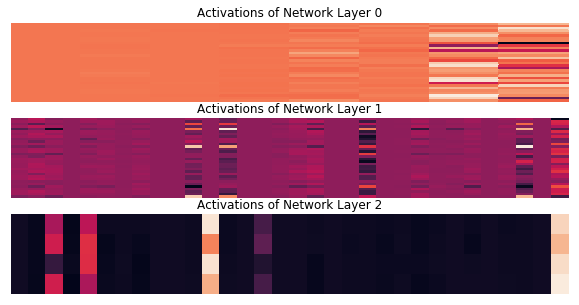

In [13]:
episode_index = -50
visualize_state(episode_history['world_image'][episode_index])
visualize_activations(agent.dqn_agent.qnetwork_local, episode_history['state'][episode_index])

In [14]:
from model import MLP

mental_states = [
    ["I believe I'm falling to fast", lambda state: state[3] < -0.2],
    ["I desire to land", lambda state: True],
    ["I desire to go left", lambda state: state[0] > 0.1],
    ["I desire to go right", lambda state: state[0] < -0.1],
]
MLP(num_neurons=1408, num_mental_states=len(mental_states), fc_units=32)

class TrainedMentalAgent(TrainedBehaviorAgent):
    
    name = 'trained_mental_agent'

    def __init__(self):
        super(TrainedMentalAgent, self).__init__()
        self.mental_state_classifier = MLP(num_neurons=1408, num_mental_states=len(mental_states), fc_units=32)
        self.mental_state_classifier.load_state_dict(torch.load('../mental_classifer.pth'))
        self.mental_state_classifier.cpu()
        self.mental_states = mental_states
        
    def report_mental_state(self, state):
        brain_state = self.brain_state(state)
        brain_state = np.concatenate([array.flatten() for array in brain_state])
        mental_state = F.sigmoid(self.mental_state_classifier(torch.tensor(brain_state))).detach().clone().cpu().numpy()
        return [agent.mental_states[i][0] for i, m in enumerate(mental_state) if m > 0.5]


agent = TrainedMentalAgent()

episode_history = world.run_episode(agent)

/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
/home/josh/.local/share/virtualenvs/tsc-2019-jd39_7cJ/lib/python3.5/site-packages/torch/nn/functional.py:1386: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


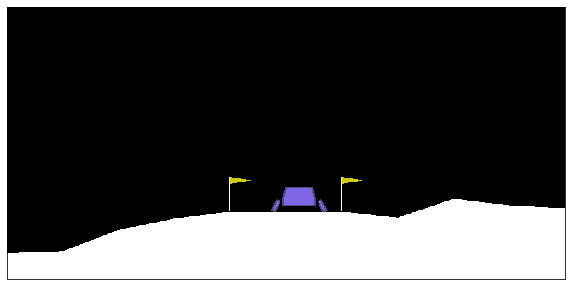

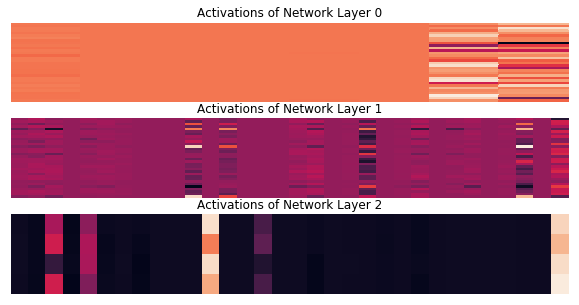

In [18]:
for i in range(0, len(episode_history['state']), 25):
    episode_index = i
    visualize_state(episode_history['world_image'][episode_index])
    visualize_activations(agent.dqn_agent.qnetwork_local, episode_history['state'][episode_index])
    clear_output()
    print('\n'.join(episode_history['reported_mental_state'][episode_index]))
    plt.pause(2)

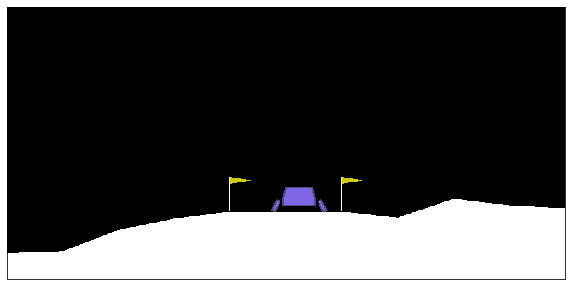

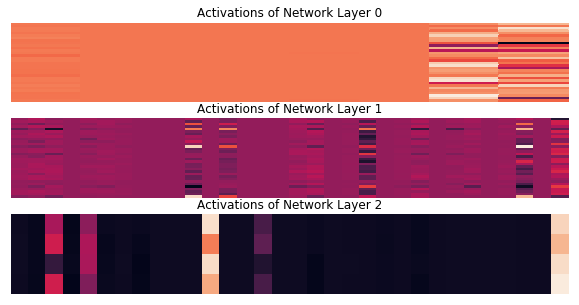

In [20]:
from visualization_utils import animate_episode_history

animate_episode_history(episode_history, agent)